# Bottle Category – Evaluation & Visualisation  
*Confusion Matrix • ROC–AUC • Grad‑CAM*

In [2]:
import os, json, numpy as np, torch, matplotlib.pyplot as plt, seaborn as sns
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

from torchcam.methods import SmoothGradCAMpp   # pip install torchcam
from torchcam.utils import overlay_mask
from PIL import Image

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BASE = "C:/Users/nitro/defect_detection_project/data/classifier_data/bottle"
MODEL_PATH = "C:/Users/nitro\/defect_detection_project/models/resnet18_bottle_best.pth"
CLASS_NAMES = ["defect","good"]

tfm = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
test_set = datasets.ImageFolder(os.path.join(BASE,"test"), tfm)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

In [3]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# match training setup: freeze all, unfreeze layer4+fc
for p in model.parameters(): p.requires_grad = False
for n,p in model.named_parameters():
    if any(k in n for k in ["layer4","fc"]): p.requires_grad = True
in_f = model.fc.in_features
model.fc = torch.nn.Sequential(torch.nn.Dropout(0.5), torch.nn.Linear(in_f,2))
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval().to(DEVICE)
print("Model loaded.")

C:\Users\nitro\AppData\Local\Temp\ipykernel_39160\2940689351.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DE

Model loaded.


In [4]:
y_true, y_prob = [], []
with torch.no_grad():
    for x, y in test_loader:
        out = model(x.to(DEVICE)).cpu()
        prob = torch.softmax(out,1)[:,1]
        y_prob.extend(prob.numpy())
        y_true.extend(y.numpy())
y_true = np.array(y_true)
y_prob = np.array(y_prob)
y_pred = (y_prob>0.5).astype(int)

print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

      defect       1.00      0.98      0.99        53
        good       0.95      1.00      0.98        20

    accuracy                           0.99        73
   macro avg       0.98      0.99      0.98        73
weighted avg       0.99      0.99      0.99        73



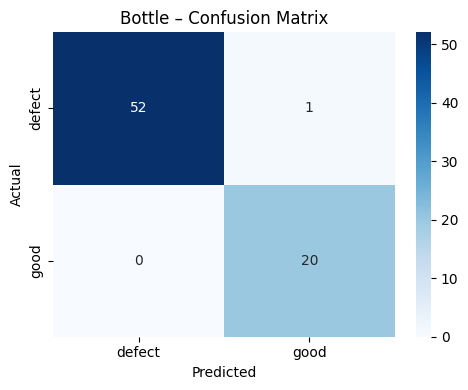

In [5]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Bottle – Confusion Matrix")
plt.tight_layout(); plt.show()

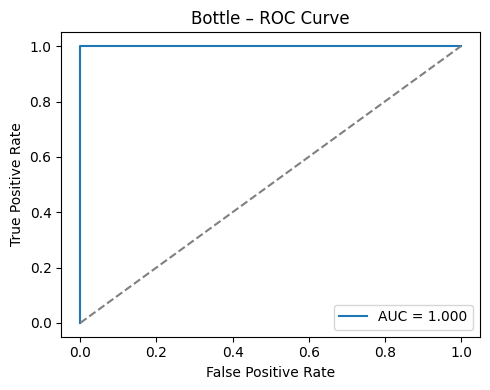

In [6]:
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Bottle – ROC Curve"); plt.legend(); plt.tight_layout(); plt.show()

In [7]:
print(f"Final Test Accuracy: {(y_pred == y_true).mean() * 100:.2f}%")

Final Test Accuracy: 98.63%
